In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def percentile_lo (x): 
    return np.percentile(x, q=10)
def percentile_hi (x): 
    return np.percentile(x, q=90)

In [2]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
# df = pd.read_csv('./../../data/processed/.csv')

Mbool = 0
sales = df.loc[df.IMPORT == Mbool].groupby(['ID', 'YEAR'])['VART'].sum().unstack()

sales = sales.loc[sales.sum(1).sort_values().index]

logsales = np.log10(sales)
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

sizes = sales.loc[sales.sum(1).sort_values().index].sum(1)

Q = 10
parts = pd.cut(sizes.cumsum()/sizes.sum(), Q, labels = range(Q)).sort_index()

## Effective Nq
eff_nq = sales.groupby(parts).count().mean(1).round().astype(int)
eff_nq

# emp_nqs = np.round(nq.sort_values()).astype(int)
partition = eff_nq.astype(int)
ss = np.arange(0.1, .8, .1)
M = 100

T = 17

In [3]:
q_stds = np.log10(sales).std(1).groupby(parts).std().iloc[1:-1]
q_stds

1    0.429017
2    0.477018
3    0.514271
4    0.534906
5    0.508053
6    0.478164
7    0.613140
8    0.438453
dtype: float64

In [4]:
# yqs = sales.groupby(parts).sum()a
# yqs.T.cov().sum().sum()

In [5]:
# colors:

# blue
#1f77b4

color_1 = '#2ca02c' # green, fits
color_2 = '#d62728' # red, analytical exps

# Linewidths:
lw_er = .5 # experiment results
lw_ae = 1 # analytical expressions
lw_fits = 1 # analytical expressions


In [6]:
### Functions for analytic expressions of moments

l10 = np.log(10)

def E_N(m, s):
    return 10**(m + s**2 *l10/2)

def E_L_smalls(m, s):
    return 10**(m + s**2 *l10/2)

def E_L(th, s):
    return 10**(th)/(1 - s**2*l10**2/2)

def var_N(m, s, T = 17):
    return 10**(2*m + s**2 * l10) * (10**(s**2 * l10) - 1)*T/(T - 1)

def var_L(th, s, T = 17):
    return l10*2*10**(2*th)*s**2*(s**2 + 4)/(s**2 - 2)**2/(2*s**2 - 1)**2*T/(T - 1)

def var_L_smalls(th, s, T = 17):
    return l10*2*10**(2*th)*(s**2 + 13*s**4/4)*T/(T - 1)


## Fit to theoretical deduction with "narrow bin" approximation

# Plots:

## - E[s\*]
## - var[s\*]
    [-] when mu = 0
        [-] as f(sigma)
        [-] as f(nq)
        
    [-] when sigma << 1
        [-] as f(mu)
        [-] as f(nq)
    
Repeat for:
## - E[log(s\*)] \approx log(E[s\*])
## - var[log(s\*)] ~ var[log(s\*)]/ln2(10) E2[s*]

In [7]:
### File name index:

# filename = 'E_mu0_fsigma'
# filename = 'E_mu0_fnq'
# filename = 'E_sigma0_fmu'
# filename = 'E_sigma0_fnq'

# filename = 'var_mu0_fsigma'
# filename = 'var_mu0_fnq'
# filename = 'var_sigma0_fmu'
# filename = 'var_sigma0_fnq'

# filename = 'Elog_mu0_fsigma'
# filename = 'Elog_mu0_fnq'
# filename = 'Elog_sigma0_fmu'
# filename = 'Elog_sigma0_fnq'

# filename = 'varlog_mu0_fsigma'
# filename = 'varlog_mu0_fnq'
# filename = 'varlog_sigma0_fmu'
# filename = 'varlog_sigma0_fnq'

# Moments of s\* = Sq/Sq0

In [8]:
result = pd.read_csv('./experiment_3.csv', usecols = ['dist', 's', 'mu', 'nq', 'repeat', 'mean_ratio', 'std_ratio', 'var_ratio'])
result = result.rename(columns = {'mean_ratio': 'mean', 'std_ratio' : 'std', 'var_ratio': 'var'})
result['log_var'] = np.log10(result['var'])
result.head()

,dist,s,mu,nq,repeat,mean,std,var,log_var
0,norm,0.1,0.0,4212,0,1.027992,0.004581,0.000021,-4.678044
1,norm,0.1,0.0,4212,1,1.025738,0.004398,0.000019,-4.713488
2,norm,0.1,0.0,4212,2,1.026318,0.002923,0.000009,-5.068251
3,norm,0.1,0.0,4212,3,1.027716,0.003463,0.000012,-4.921163
4,norm,0.1,0.0,4212,4,1.026964,0.002398,0.000006,-5.240417


In [9]:
# # data = result.loc[(result.dist == 'lapl') & (result.s > .6)]

# # y = np.log10(data[['var']]).values
# # X = np.log10(data[['nq']]).values

# a = LinearRegression().fit(X, y)
# a.coef_
# # a?

### Fit alphas

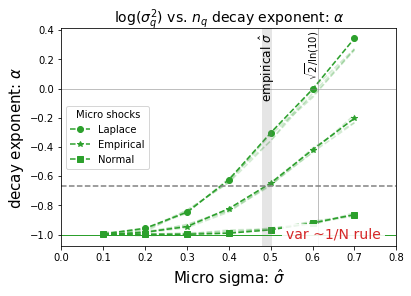

In [10]:
from sklearn.linear_model import LinearRegression

def model(df):
    y = np.log10(df[['var']]).values
    X = np.log10(df[['nq']]).values
    return np.squeeze(LinearRegression().fit(X, y).coef_)

def group_predictions(df):
    return df.groupby(['dist', 's', 'mu']).apply(model)

alphas = pd.DataFrame(group_predictions(result), columns = ['alpha']).astype(float)

fig, ax = plt.subplots()

data = alphas.unstack()['alpha'][[0.0]]

for i, dist in enumerate(['lapl', 'emp', 'norm']):
    data.loc[dist].plot(marker = ['o', '*', 's'][i], linestyle = '--', ax = ax, c = color_1)
    

for mu in alphas.reset_index().mu.unique():
    alphas.unstack()['alpha'][[mu]].unstack(0).plot(linestyle = '--', ax = ax, c = color_1, alpha = .2, label = '_')
    
ax.legend(['Laplace', 'Empirical', 'Normal'], title = 'Micro shocks')


ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
ax.axhline(-0.665, linestyle = '--', c = '.5')
ax.axhline(-1, linestyle = '-', lw = 1, color = color_1)
ax.annotate('empirical '+r'$\hat \sigma$', xy = (0.491, .15), va = 'center', ha = 'center', rotation = 90, fontsize = 12)


ax.axvline(np.sqrt(2)/np.log(10), c = '.5', alpha = .5, lw = 1)
ax.axhline(0, c = '.5', alpha = .5, lw = 1)
ax.annotate(r'$\sqrt{2}/\ln(10)$', xy = (0.6, .23), color = 'k', fontsize = 10, va = 'center', ha = 'center', rotation = 90)#, bbox=dict(fc="w", lw=0, alpha = .9))


ax.annotate('var ~1/N rule', xy = (0.65, -1), color = color_2, fontsize = 14, va = 'center', ha = 'center', bbox=dict(fc="w", lw=0, alpha = .9))

ax.set_title(r'$\log(\sigma_q^2)$'+' vs. '+r'$n_q$'+' decay exponent: '+r'$\alpha$', fontsize = 14)
ax.set_xlabel('Micro sigma: '+r'$\hat \sigma$', fontsize = 15)
ax.set_ylabel('decay exponent: '+r'$\alpha$', fontsize = 15)

plt.xlim(0, .8)

plt.savefig('./../../../WRITING/FIGURES/trade/alphas_sigma_lin.png')
plt.show()

## E[s\*]

    [-] when mu = 0
        [-] as f(sigma)
    

In [11]:
alphas = alphas.groupby(level = (0, 1)).mean().unstack()
alphas

alpha                                                            
s          0.1       0.2       0.3       0.4       0.5       0.6       0.7
dist                                                                      
emp  -0.999477 -0.983686 -0.941016 -0.832430 -0.653954 -0.422425 -0.209939
lapl -0.990635 -0.966055 -0.841156 -0.631267 -0.327307 -0.030310  0.283902
norm -0.999591 -0.999695 -0.993508 -0.981005 -0.960851 -0.918781 -0.863902

In [12]:
filename = 'E_mu0_fsigma'

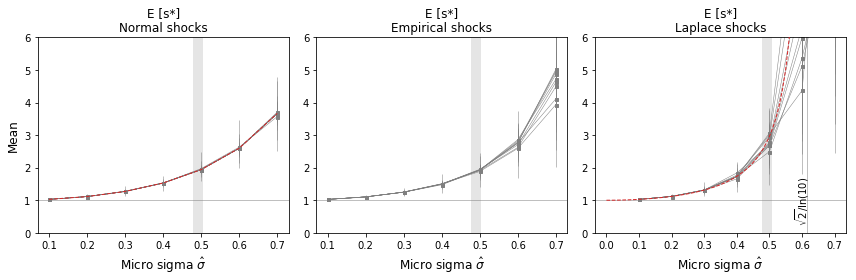

In [13]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

data = result.loc[result.mu == 0]

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
m = np.zeros(x.shape)
ax.plot(x, E_N(m, x), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

###
    
    
#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['nq', 's'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[1]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


# for s in q_stds.values:
#     ax.axvline(s, c = '.5', alpha = .1, lw = 10)

#################

# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[2]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

## Analytical expectation
# s = x[np.where(x < 0.61)]
s = np.arange(0, 0.61, 0.01)
th = np.zeros(s.shape)
ax.plot(s, E_L(th, s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)



for l in range(3):
    ax = axs[l]

    ax.set_xlabel('Micro sigma '+r'$\hat \sigma$', fontsize = 12)
    ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)

    ax.set_title('E [s*]\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(0, 6)
    ax.axhline(1, lw = 0.5, c = '.5')
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
        
    if l == 2:
        ax.axvline(np.sqrt(2)/np.log(10), c = '.5', alpha = .5, lw = 1)
        ax.annotate(r'$\sqrt{2}/\ln(10)$', xy = (0.6, 1), color = 'k', fontsize = 10, va = 'center', ha = 'center', rotation = 90)#, bbox=dict(fc="w", lw=0, alpha = .9))


        

plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## E[s\*]

    [-] when mu = 0
        [-] as f(nq) for many sigma
    

In [14]:
filename = 'E_mu0_fnq'

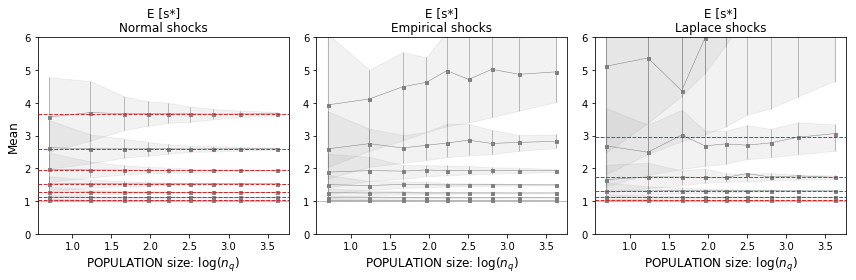

In [15]:
poly_list = []

mu0 = 0
data = result.loc[result.mu == mu0]


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)
   
    ## Analytical expectation 
    ax.axhline(E_N(mu0, s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[1]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)


#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[2]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)

    ## Analytical expectation 
    ax.axhline(E_L(mu0, s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)
    ax.set_title('E [s*]\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)

    ax.set_ylim(0, 6)
    ax.axhline(1, lw = 0.5, c = '.5')
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## var[s\*]

    [-] when mu = 0
        [-] as f(sigma)
    

In [16]:
filename = 'var_mu0_fsigma'

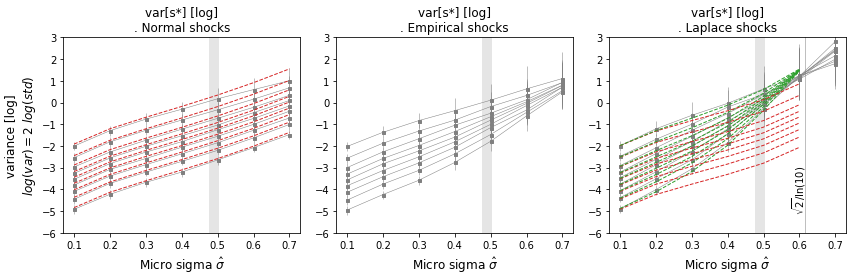

In [17]:
data = result.loc[result.mu == 0]


fig, axs = plt.subplots(1, 3, figsize = (12, 4))


#################
# Normal

ax = axs[0]

plot_data = data.loc[data.dist == 'norm'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

## Analytical expectation
for n0 in partition.values[1:]:
    m = np.zeros(x.shape)
    ## If I add also the intercept of the regression I could do:
#     ax.plot(x, np.log10(var_N(m, x)) + alphas.loc['norm'].values.flatten()*np.log10(n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    ax.plot(x, np.log10(var_N(m, x)) - np.log10(n0), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

#################
# Empirical

ax = axs[1]

plot_data = data.loc[data.dist == 'emp'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)



#################
# Laplace

ax = axs[2]

plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
for n0 in partition.values[1:]:
    s = x[np.where(x < 0.61)]
    m = np.zeros(s.shape)
    ax.plot(s, np.log10(var_L(m, s)) - np.log10(n0), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    ax.plot(s, np.log10(var_L(m, s)) + (alphas.loc['lapl'].values.flatten()*np.log10(n0))[:len(s)], color = color_1, linestyle = '--', zorder = 10, lw = lw_fits)

    
for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro sigma '+r'$\hat \sigma$', fontsize = 12)
    ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)
        
    ax.set_title('var[s*] [log]\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 3)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)
    if l == 2:
        ax.axvline(np.sqrt(2)/np.log(10), c = '.5', alpha = .5, lw = 1)
        ax.annotate(r'$\sqrt{2}/\ln(10)$', xy = (0.6, -4), color = 'k', fontsize = 10, va = 'center', ha = 'center', rotation = 90)#, bbox=dict(fc="w", lw=0, alpha = .9))

    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## var[s\*]

    [-] when mu = 0
        [-] as f(nq) for many sigma
    

In [18]:
filename = 'var_mu0_fnq'

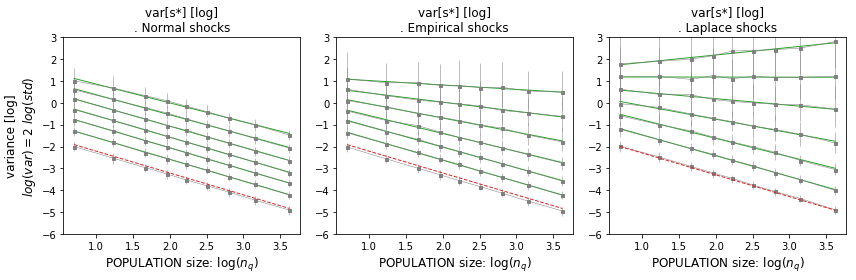

In [19]:
poly_list = []

data = result.loc[result.mu == 0]

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(var_N(mu0, s0)) - np.log10(y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['norm', s0, poly[0], poly[1]]]
    


#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(var_N(mu0, s0)) - np.log10(y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['emp', s0, poly[0], poly[1]]]
    
    
#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## Fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(var_L_smalls(mu0, s0)) - np.log10(y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['lapl', s0, poly[0], poly[1]]]
    
    
######### Plot details
for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)


    ax.set_title('var[s*] [log]\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 3)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)


plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## - E[s\*]
    [-] when sigma << 1
        [-] as f(mu)

In [20]:
filename = 'E_sigma0_fmu'

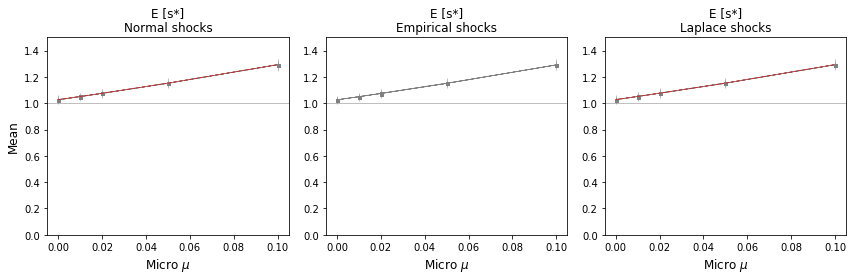

In [21]:

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
###
## Analytical expectation
m = x
s = np.ones(x.shape)*micro_s
ax.plot(x, E_N(m, s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


    
#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['nq', 'mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[1]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


#################

# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[2]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


## Analytical expectation
th = x
s = np.ones(x.shape)*(micro_s)

ax.plot(x, E_L(th, s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro '+r'$\mu$', fontsize = 12)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)

    ax.set_title('E [s*]\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(0, 1.5)
    ax.axhline(1, c = '.5', lw = .5)
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)



plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## - E[s\*]
    [-] when sigma << 1
        [-] as f(nq), for many mu

In [22]:
filename = 'E_sigma0_fnq'

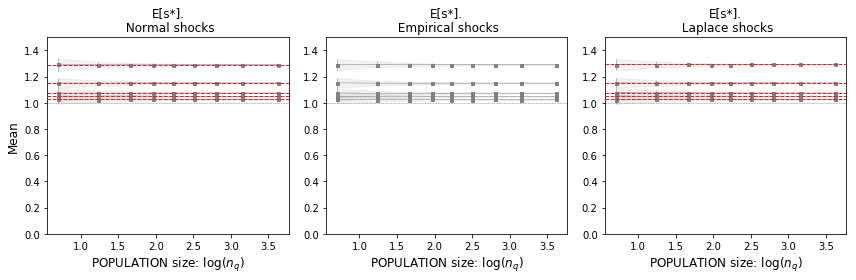

In [23]:
poly_list = []

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ax.axhline(E_N(m, micro_s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)


ax.axhline(1, color = '.5', lw = .5, linestyle = '--')


#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[1]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)

ax.axhline(1, color = '.5', lw = .5, linestyle = '--')


#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[2]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)
 
    ## Analytical expectation 
    ax.axhline(E_L(m, micro_s), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    

ax.axhline(1, color = '.5', lw = .5, linestyle = '--')

for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)

    ax.set_title('E[s*].\n '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(0, 1.5)
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## - var[s\*]
    [-] when sigma << 1
        [-] as f(mu)

In [24]:
filename = 'var_sigma0_fmu'

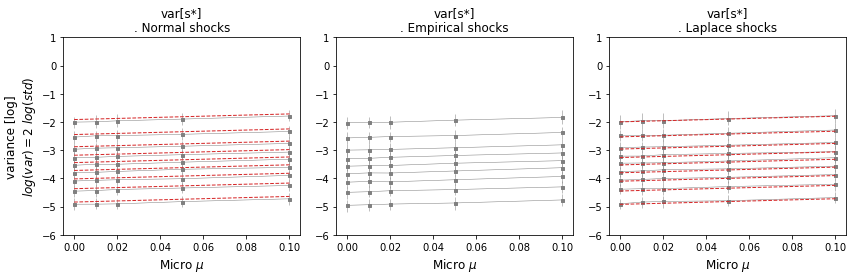

In [25]:

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))


#################
# Normal

ax = axs[0]

plot_data = data.loc[data.dist == 'norm'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values # mu

for n in y_data.index.values:
    ax.errorbar(x, y_data.loc[n], yerr=[ylo_data.loc[n], yhi_data.loc[n]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ## Analytical expectation
    ax.plot(x, np.log10(var_N(x, micro_s)/n), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    
#################
# Empirical

ax = axs[1]

plot_data = data.loc[data.dist == 'emp'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

#################
# Laplace

ax = axs[2]

plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values


for n in y_data.index.values:
    ax.errorbar(x, y_data.loc[n], yerr=[ylo_data.loc[n], yhi_data.loc[n]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ## Analytical expectation
#     ax.plot(x, var_L(x, micro_s) - np.log10(n) , color = 'r', linestyle = '--', zorder = 10, lw = .5)
    ax.plot(x, np.log10(var_L_smalls(x, micro_s)/n) , color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro '+r'$\mu$', fontsize = 12)
#     ax.axvline(np.log10(0.491), linestyle = '--', c = '.5')
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)
        

    ax.set_title('var[s*]\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 1)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)

    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## - var[s\*]
    [-] when sigma << 1
        [-] as f(nq) for many mu

In [26]:
filename = 'var_sigma0_fnq'

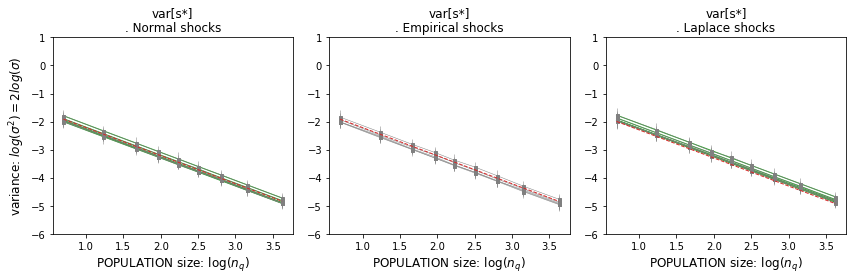

In [27]:
poly_list = []

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for mu in mus:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[mu], 1)
    poly = np.poly1d(z)

    ax.plot(x, poly(x), c = color_1, lw = lw_fits)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
   
    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_N(m, s)) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

        
    poly_list += [['norm', mu, poly[0], poly[1]]]
    

#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 



for mu in mus:

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_N(m, s)) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    
    
#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for mu in mus:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[mu], 1)
    poly = np.poly1d(z)

    ax.plot(x, poly(x), c = color_1, lw = lw_fits)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_L_smalls(m, s)) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    poly_list += [['norm', mu, poly[0], poly[1]]]
    
    
######### Plot details
for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)


    ax.set_title('var[s*]\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 1)
    if l ==0: ax.set_ylabel('variance: '+r'$log(\sigma ^2) = 2 log(\sigma)$', fontsize = 12)

plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

# Repeat for moments of log(s*):

In [28]:
result = pd.read_csv('./experiment_3.csv', usecols = ['dist', 'mu', 's', 'nq', 'repeat', 'mean_log_ratio', 'std_log_ratio', 'var_log_ratio'])
result = result.rename(columns = {'mean_log_ratio': 'mean', 'std_log_ratio' : 'std', 'var_log_ratio': 'var'})
result['log_var'] = np.log10(result['var'])
result.head()

,dist,s,mu,nq,repeat,mean,std,var,log_var
0,norm,0.1,0.0,4212,0,0.011985,0.001936,0.000004,-5.425970
1,norm,0.1,0.0,4212,1,0.011032,0.001861,0.000003,-5.460709
2,norm,0.1,0.0,4212,2,0.011280,0.001236,0.000002,-5.815970
3,norm,0.1,0.0,4212,3,0.011871,0.001463,0.000002,-5.669407
4,norm,0.1,0.0,4212,4,0.011554,0.001014,0.000001,-5.987685


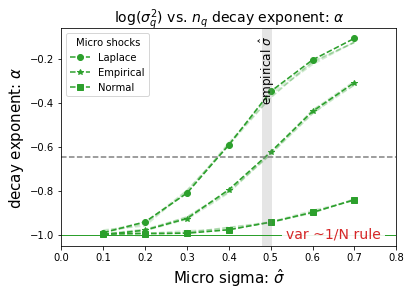

In [29]:
from sklearn.linear_model import LinearRegression

def model(df):
    y = np.log10(df[['var']]).values
    X = np.log10(df[['nq']]).values
    return np.squeeze(LinearRegression().fit(X, y).coef_)

def group_predictions(df):
    return df.groupby(['dist', 's', 'mu']).apply(model)

alphas = pd.DataFrame(group_predictions(result), columns = ['alpha']).astype(float)

fig, ax = plt.subplots()

data = alphas.unstack()['alpha'][[0.0]]

for i, dist in enumerate(['lapl', 'emp', 'norm']):
    data.loc[dist].plot(marker = ['o', '*', 's'][i], linestyle = '--', ax = ax, c = color_1)
    

for mu in alphas.reset_index().mu.unique():
    alphas.unstack()['alpha'][[mu]].unstack(0).plot(linestyle = '--', ax = ax, c = color_1, alpha = .2, label = '_')
    
ax.legend(['Laplace', 'Empirical', 'Normal'], title = 'Micro shocks')


ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
ax.axhline(-0.645, linestyle = '--', c = '.5')
ax.axhline(-1, linestyle = '-', lw = 1, color = color_1)
ax.annotate('empirical '+r'$\hat \sigma$', xy = (0.491, -.25), va = 'center', ha = 'center', rotation = 90, fontsize = 12)

ax.annotate('var ~1/N rule', xy = (0.65, -1), color = color_2, fontsize = 14, va = 'center', ha = 'center', bbox=dict(fc="w", lw=0, alpha = .9))

ax.set_title(r'$\log(\sigma_q^2)$'+' vs. '+r'$n_q$'+' decay exponent: '+r'$\alpha$', fontsize = 14)
ax.set_xlabel('Micro sigma: '+r'$\hat \sigma$', fontsize = 15)
ax.set_ylabel('decay exponent: '+r'$\alpha$', fontsize = 15)


plt.xlim(0, .8)

plt.savefig('./../../../WRITING/FIGURES/trade/alphas_sigma_log.png')
plt.show()

In [30]:
alphas = alphas.groupby(level = (0, 1)).mean().unstack()
alphas

alpha                                                            
s          0.1       0.2       0.3       0.4       0.5       0.6       0.7
dist                                                                      
emp  -0.999365 -0.979834 -0.924452 -0.803332 -0.629927 -0.441151 -0.311289
lapl -0.987466 -0.949266 -0.806063 -0.589549 -0.364166 -0.215189 -0.121621
norm -0.999488 -0.997501 -0.989560 -0.973588 -0.943953 -0.898112 -0.841594

## - E[log(s\*)] ~ log(E[s\*])
    [-] when mu = 0
        [-] as f(sigma)


In [31]:
filename = 'Elog_mu0_fsigma'

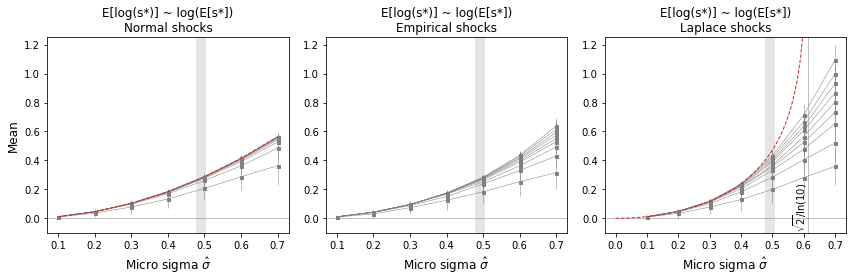

In [32]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

data = result.loc[result.mu == 0]

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
m = np.zeros(x.shape)
ax.plot(x, np.log10(E_N(m, x)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

###
    
    
#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['nq', 's'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[1]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


#################

# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[2]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

## Analytical expectation
# s = x[np.where(x < 0.61)]
s = np.arange(0, 0.61, 0.01)
th = np.zeros(s.shape)
ax.plot(s, np.log10(E_L(th, s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]

    ax.set_xlabel('Micro sigma '+r'$\hat \sigma$', fontsize = 12)
    ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)

    ax.set_title('E[log(s*)] ~ log(E[s*])\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-0.1, 1.25)
    ax.axhline(0, lw = 0.5, c = '.5')
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
    if l == 2:
        ax.axvline(np.sqrt(2)/np.log(10), c = '.5', alpha = .5, lw = 1)
        ax.annotate(r'$\sqrt{2}/\ln(10)$', xy = (0.59, 0.08), color = 'k', fontsize = 10, va = 'center', ha = 'center', rotation = 90)#, bbox=dict(fc="w", lw=0, alpha = .9))


plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

        
## - E[log(s\*)] ~ log(E[s\*])
    [-] when mu = 0
        [-] as f(nq) for many sigmas
        


In [33]:
filename = 'Elog_mu0_fnq'

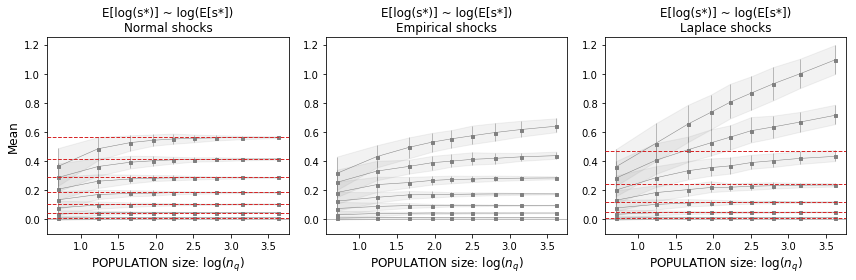

In [34]:
poly_list = []

mu0 = 0
data = result.loc[result.mu == mu0]


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)
   
    ## Analytical expectation 
    ax.axhline(np.log10(E_N(mu0, s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[1]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)


#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[2]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[s], plot_data['mean']['percentile_hi'].unstack().loc[s], color = '.5', alpha = .1)
   
    ## Analytical expectation 
    if s < 0.61: ax.axhline(np.log10(E_L(mu0, s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)
    ax.set_title('E[log(s*)] ~ log(E[s*])\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)

    ax.set_ylim(-0.1, 1.25)
    ax.axhline(0, lw = 0.5, c = '.5')
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## - var[log(s\*)] ~ var[s\*]/ln2(10) E2[s*]

    [-] when mu = 0
        [-] as f(sigma)
        


In [35]:
filename = 'varlog_mu0_fsigma'

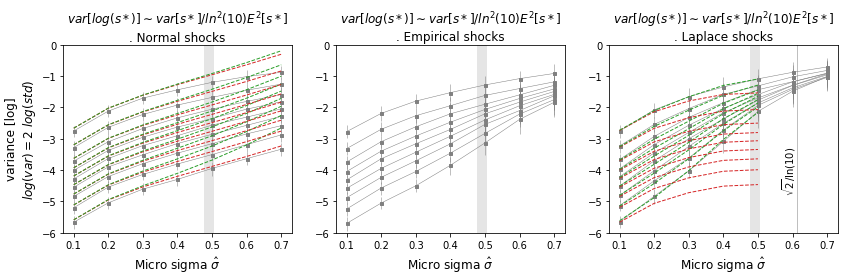

In [36]:
data = result.loc[result.mu == 0]


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal

ax = axs[0]

plot_data = data.loc[data.dist == 'norm'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

## Analytical expectation
for n0 in partition.values[1:]:
    m = np.zeros(x.shape)
    ax.plot(x, np.log10(var_N(m, x)/(l10*E_N(m, x))**2) - np.log10(n0), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    ax.plot(x, np.log10(var_N(m, x)/(l10*E_N(m, x))**2) + (alphas.loc['norm'].values.flatten()*np.log10(n0)), color = color_1, lw = lw_ae, linestyle = '--', zorder = 10)


#################
# Empirical

ax = axs[1]

plot_data = data.loc[data.dist == 'emp'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)



#################
# Laplace

ax = axs[2]

plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
for n0 in partition.values[1:]:
    s = x[np.where(x < 0.51)]
    m = np.zeros(s.shape)
    ax.plot(s, np.log10(var_L(m, s)/(l10*E_L(m, s))**2) - np.log10(n0), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    ax.plot(s, np.log10(var_L(m, s)/(l10*E_L(m, s))**2) + (alphas.loc['lapl'].values.flatten()*np.log10(n0))[:len(s)], color = color_1, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro sigma '+r'$\hat \sigma$', fontsize = 12)
    ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)
        
    ax.set_title(r'$var[log(s*)] \sim var[s*]/ln^2(10) E^2[s*]$'+'\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 0)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)
    if l == 2:
        ax.axvline(np.sqrt(2)/np.log(10), c = '.5', alpha = .5, lw = 1)
        ax.annotate(r'$\sqrt{2}/\ln(10)$', xy = (0.59, -4), color = 'k', fontsize = 10, va = 'center', ha = 'center', rotation = 90)#, bbox=dict(fc="w", lw=0, alpha = .9))

    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## - var[log(s\*)] ~ var[s\*]/ln2(10) E2[s*]

    [-] when mu = 0
        [-] as f(nq) for many sigmas



In [37]:
filename = 'varlog_mu0_fnq'

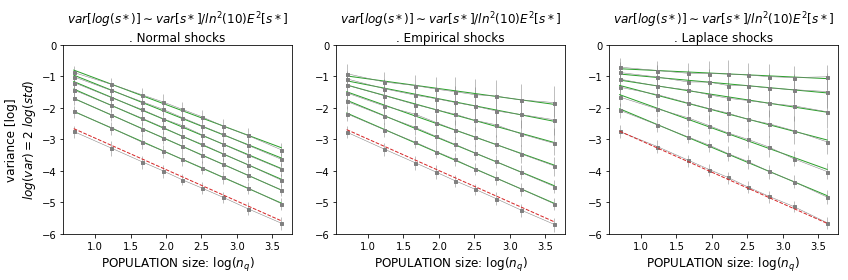

In [38]:
poly_list = []

mu0 = 0
data = result.loc[result.mu == mu0]

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    # In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(var_N(mu0, s0)/(l10*E_N(mu0, s0))**2) - np.log10(y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
        
    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['norm', s0, poly[0], poly[1]]]
    

#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['emp', s0, poly[0], poly[1]]]
    
    
#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## Fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(var_L_smalls(mu0, s0)/(l10*E_L(mu0, s0))**2) - np.log10(y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    else:
        ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
    poly_list += [['lapl', s0, poly[0], poly[1]]]
    
    
######### Plot details
for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)


    ax.set_title(r'$var[log(s*)] \sim var[s*]/ln^2(10) E^2[s*]$'+'\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 0)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)


plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## - E[log(s\*)] ~ log(E[s\*])
    [-] when sigma << 1
        [-] as f(mu)
        


In [39]:
filename = 'Elog_sigma0_fmu'

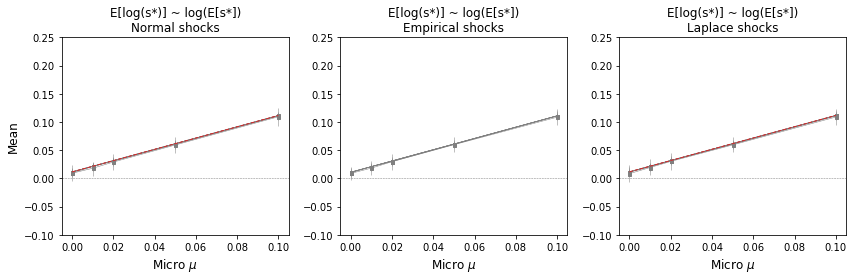

In [40]:

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
    
## Analytical expectation
m = x
s = np.ones(x.shape)*micro_s
ax.plot(x, np.log10(E_N(m, s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


    
#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['nq', 'mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[1]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


#################

# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
# plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[2]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


## Analytical expectation
th = x
s = np.ones(x.shape)*(micro_s)

ax.plot(x, np.log10(E_L(th, s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro '+r'$\mu$', fontsize = 12)
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)

    ax.set_title('E[log(s*)] ~ log(E[s*])\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-.1, .25)
    ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
    if l ==0: ax.set_ylabel('Mean', fontsize = 12)



plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## - E[log(s\*)] ~ log(E[s\*])
    [-] when sigma << 1
        [-] as f(nq) for many mus



In [41]:
filename = 'Elog_sigma0_fnq'

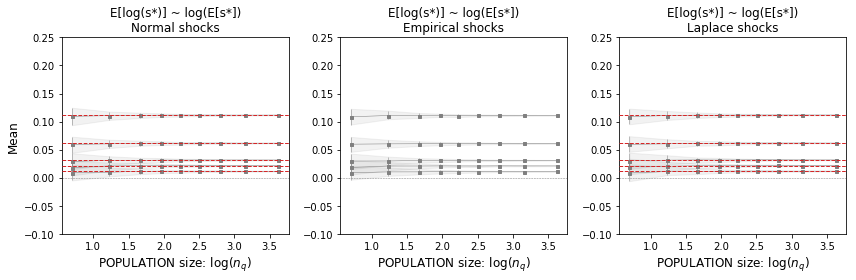

In [42]:
poly_list = []

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ax.axhline(np.log10(E_N(m, micro_s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)


ax.axhline(1, color = '.5', lw = .5, linestyle = '--')


#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[1]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)

ax.axhline(1, color = '.5', lw = .5, linestyle = '--')


#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[2]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for m in y_data.index.values:
    ax.errorbar(x, y_data.loc[m], yerr=[ylo_data.loc[m], yhi_data.loc[m]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ax.fill_between(x, plot_data['mean']['percentile_lo'].unstack().loc[m], plot_data['mean']['percentile_hi'].unstack().loc[m], color = '.5', alpha = .1)

    ## Analytical expectation 
    ax.axhline(np.log10(E_L(m, micro_s)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)



for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)

    ax.set_title('E[log(s*)] ~ log(E[s*])\n'+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-.1, .25)
    ax.axhline(0, color = '.5', lw = .5, linestyle = '--')

    if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

## - var[log(s\*)] ~ var[s\*]/ln2(10) E2[s*]

    [-] when sigma << 1
        [-] as f(mu)
        


In [43]:
filename = 'varlog_sigma0_fmu'

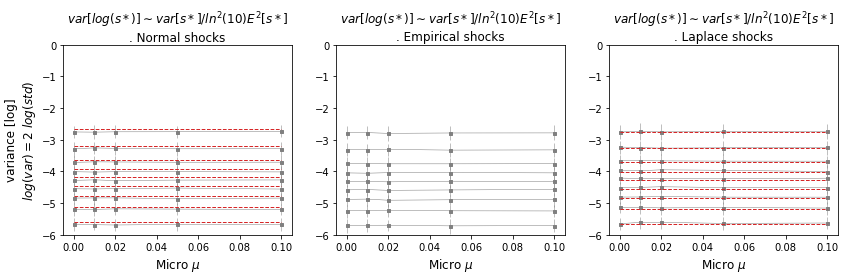

In [44]:

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()


fig, axs = plt.subplots(1, 3, figsize = (12, 4))


#################
# Normal

ax = axs[0]

plot_data = data.loc[data.dist == 'norm'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values # mu

for n in y_data.index.values:
    ax.errorbar(x, y_data.loc[n], yerr=[ylo_data.loc[n], yhi_data.loc[n]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ## Analytical expectation
    ax.plot(x, np.log10(var_N(x, micro_s)/(l10*E_N(x, micro_s))**2) - np.log10(n), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    
#################
# Empirical

ax = axs[1]

plot_data = data.loc[data.dist == 'emp'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

#################
# Laplace

ax = axs[2]

plot_data = data.loc[data.dist == 'lapl'].groupby(['nq','mu'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = y_data.columns.values


for n in y_data.index.values:
    ax.errorbar(x, y_data.loc[n], yerr=[ylo_data.loc[n], yhi_data.loc[n]], lw = .5, color = '.5', marker = 's', markersize = 3)
    ## Analytical expectation
#     ax.plot(x, var_L(x, micro_s) - np.log10(n) , color = 'r', linestyle = '--', zorder = 10, lw = .5)
    ax.plot(x, np.log10(var_L_smalls(x, micro_s)/(l10*E_L(x, micro_s))**2) - np.log10(n), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


for l in range(3):
    ax = axs[l]
    ax.set_xlabel('Micro '+r'$\mu$', fontsize = 12)
#     ax.axvline(np.log10(0.491), linestyle = '--', c = '.5')
#         if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
#         if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)
        

    ax.set_title(r'$var[log(s*)] \sim var[s*]/ln^2(10) E^2[s*]$'+'\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 0)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)

    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## - var[log(s\*)] ~ var[s\*]/ln2(10) E2[s*]

    [-] when sigma << 1
        [-] as f(nq) for many 

In [45]:
filename = 'varlog_sigma0_fnq'

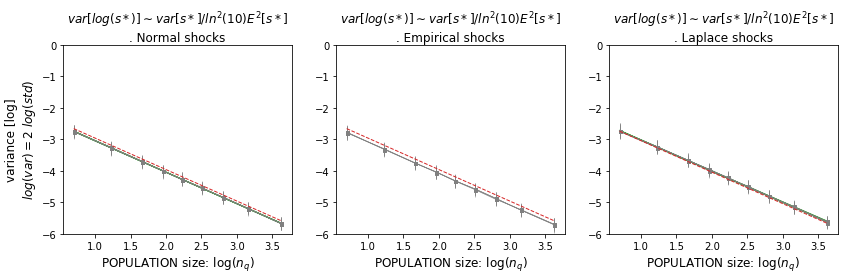

In [46]:
poly_list = []

micro_s = result.s.min()
data = result.loc[result.s == micro_s]
mus = data.mu.unique()

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

#################
# Normal
plot_data = data.loc[data.dist == 'norm'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for mu in mus:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[mu], 1)
    poly = np.poly1d(z)

    ax.plot(x, poly(x), c = color_1, lw = lw_fits)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)

    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_N(m, s)/(l10*E_N(m, s))**2) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

        
    poly_list += [['norm', mu, poly[0], poly[1]]]
    

#################
# Empirical Shocks
plot_data = data.loc[data.dist == 'emp'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

for mu in mus:
    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_N(m, s)/(l10*E_N(m, s))**2) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

    
#################
# Laplace
plot_data = data.loc[data.dist == 'lapl'].groupby(['mu','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for mu in mus:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[mu], 1)
    poly = np.poly1d(z)

    ax.plot(x, poly(x), c = color_1, lw = lw_fits)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if mu == min(mus): 
        logn = x
        s = np.ones(n.shape)*micro_s
        m = np.ones(n.shape)*mu
        ax.plot(x, np.log10(var_L_smalls(m, s)/(l10*E_L(m, s))**2) - logn, color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)


    poly_list += [['norm', mu, poly[0], poly[1]]]
    
    
######### Plot details
for l in range(3):
    ax = axs[l]
    ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)


    ax.set_title(r'$var[log(s*)] \sim var[s*]/ln^2(10) E^2[s*]$'+'\n'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
    ax.set_ylim(-6, 0)
#     if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)
    if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)$', fontsize = 12)

plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

In [47]:
alphas = pd.DataFrame(group_predictions(result), columns = ['alpha']).astype(float)
a = alphas.groupby(level = (0, 1)).mean().unstack()['alpha'][0.5]
ns = np.array(sorted(result.nq.unique()))

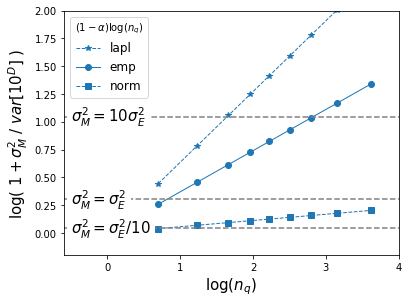

In [48]:

fig, axs = plt.subplots(1, figsize = (6, 4.5))
# axs.set_title('Firm level comovement')

x = np.log10(ns)

for i in [1, 0, 2]:
    alpha = a.values[i]; dist = a.index.values[i]
#     print((1 + alpha))
    axs.plot(x, (1 + alpha)*x, marker = ['o', '*', 's'][i], linestyle = ['-', '--', '--'][i], label = dist, color = '#1f77b4', lw = 1)
#     axs.plot(x, 0.05*x)
    
axs.axhline(np.log10(1 + 10), c = '.5', linestyle = '--')
axs.annotate(xy = (-.5, np.log10(1 + 10)), s = r'$\sigma^2_M = 10 \sigma^2_E$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))
axs.axhline(np.log10(1 + 1), c = '.5', linestyle = '--')
axs.annotate(xy = (-.5, np.log10(2)), s = r'$\sigma^2_M = \sigma^2_E$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))
axs.axhline(np.log10(1 + .1), c = '.5', linestyle = '--')
axs.annotate(xy = (-.5, np.log10(1.1)), s = r'$\sigma^2_M = \sigma^2_E/10$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))

plt.xlabel(r'$\log(n_q)$', fontsize = 15)
plt.ylabel(r'$\log(\ 1 + \sigma^2_M\ /\ var[10^D]\ )$', fontsize = 15)

plt.xlim(-.6, 4)
plt.ylim(-.2, 2)
plt.legend(title = r'$(1 - \alpha) \log(n_q)$', fontsize = 12, loc = 'upper left')
plt.savefig('./../../../WRITING/FIGURES/trade/alpha_comov_'+str(Mbool)+'.png')
plt.show()

In [49]:
xx

NameError: name 'xx' is not defined

In [ ]:

fig, axs = plt.subplots()

x = np.log10(ns)

for i in range(3):
    alpha = a.values[i]; dist = a.index.values[i]
#     axs.plot(ns, (ns**(alpha) - 1/ns)/(1 - ns**(alpha)), marker = '.', label = dist)
    axs.plot(ns, (ns**(alpha) - 1/ns)/(1 - ns**(alpha)), marker = '.', label = dist)
    
# axs.axhline(np.log10(1 + 10), c = '.5', linestyle = '--')
# axs.annotate(xy = (-.4, np.log10(1 + 10)), s = r'$\sigma^2_M = 10 \sigma^2_E$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))
# axs.axhline(np.log10(1 + 1), c = '.5', linestyle = '--')
# axs.annotate(xy = (-.4, np.log10(2)), s = r'$\sigma^2_M = \sigma^2_E$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))
# axs.axhline(np.log10(1 + .1), c = '.5', linestyle = '--')
# axs.annotate(xy = (-.4, np.log10(1.1)), s = r'$\sigma^2_M = \sigma^2_E/10$', fontsize = 15, va = 'center', ha = 'left', bbox=dict(fc="w", lw=0))

plt.xlabel(r'$n_q\ [log]$', fontsize = 15)
plt.ylabel(r'$\sigma^2_M\ /\ \sigma^2_E$', fontsize = 15)

# plt.xlim(-.5, 4)
# plt.ylim(-.2, 2)
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
xx

### vs log(nq)

In [ ]:
# poly_list = []

# fig, axs = plt.subplots(2, 3, figsize = (12, 6))

# #################
# # Normal
# plot_data = result.loc[result.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

# ax = axs[0][0]

# y_data = plot_data['mean']['mean'].unstack()
# yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
# ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)

# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')

    
# #################

# ax = axs[1][0]

# # logplot_data = np.log10(plot_data)
# y_data = plot_data['log_var']['mean'].unstack()
# yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
# ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)

# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# for s0 in ss:
#     ## For all others, fit line (green)
#     z = np.polyfit(x, y_data.loc[s0], 1)
#     poly = np.poly1d(z)

#     ## In the small fluctuations limit this is valid (Im using the lognormal expression)
#     if s0 == min(ss): 
#         ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
#     else:
#         ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
#     poly_list += [['norm', s0, poly[0], poly[1]]]
    

# #################
# # Empirical Shocks
# plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# ax = axs[0][1]

# y_data = plot_data['mean']['mean'].unstack()
# yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
# ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)

# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')

# #################
    
# ax = axs[1][1]

# # logplot_data = np.log10(plot_data)
# y_data = plot_data['log_var']['mean'].unstack()
# yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
# ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)
# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# # sqrt(sobs2 - (strend)2) = (sq)
# # ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

# for s0 in ss:
#     ## For all others, fit line (green)
#     z = np.polyfit(x, y_data.loc[s0], 1)
#     poly = np.poly1d(z)

#     ## In the small fluctuations limit this is valid (Im using the lognormal expression)
#     if s0 == min(ss): 
#         ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
#     else:
#         ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
#     poly_list += [['emp', s0, poly[0], poly[1]]]
    
    
# #################
# # Laplace
# plot_data = result.loc[result.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


# ax = axs[0][2]

# y_data = plot_data['mean']['mean'].unstack()
# yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
# ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)

# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')


# #################
    
# ax = axs[1][2]

# # logplot_data = np.log10(plot_data)
# y_data = plot_data['log_var']['mean'].unstack()
# yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
# ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)

# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# for s0 in ss:
#     ## Fit line (green)
#     z = np.polyfit(x, y_data.loc[s0], 1)
#     poly = np.poly1d(z)

#     ## In the small fluctuations limit this is valid (Im using the lognormal expression)
#     if s0 == min(ss): 
#         ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)
#     else:
#         ax.plot(x, poly(x), c = color_1, lw = lw_fits)
        
#     poly_list += [['lapl', s0, poly[0], poly[1]]]
    
    
# for k in range(2):
#     for l in range(3):
#         ax = axs[k][l]
#         ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)

#         if k == 0: ## Plots of mean
#             ax.set_title('E[s*]\n '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
#             ax.set_ylim(-.1, 1.5)
#             if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
#         if k == 1: ## Plots of variance
#             ax.set_title(r'$\log(\sigma_q^2)$'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
#             ax.set_ylim(-6.3, 0)
#             if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)


# plt.tight_layout()
# plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

# plt.show(), fontsize = 12)


# plt.tight_layout()
# plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

# plt.show()

## Decay with nq

In [ ]:
fig, ax = plt.subplots()

alphas = pd.DataFrame(poly_list, columns = ['gdist', 'micro_s', 'const', 'alpha'])

for i, dist in enumerate(['lapl', 'emp', 'norm']):
    data = alphas.loc[alphas.gdist == dist]
    
    ax.plot(data.micro_s.values, data.alpha.values, marker = ['o', '*', 's'][i], c = 'g', lw = .5, markersize = 5, label  =['Laplace', 'Empirical', 'Normal'][i])
    ax.axhline(-1, linestyle = '-', c = 'g', lw = .25)
    ax.set_xlim(0, .8)
    
ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
ax.axhline(-0.645, linestyle = '--', c = '.5')
ax.annotate('empirical '+r'$\hat \sigma$', xy = (0.491, -.25), va = 'center', ha = 'right', rotation = 90, fontsize = 12)

ax.annotate('var ~1/N rule', xy = (0.65, -.98), ha = 'center', color = 'g', fontsize = 11)


ax.set_title(r'$\log(\sigma_q^2)$'+' vs. '+r'$n_q$'+' decay exponent: '+r'$\alpha$', fontsize = 14)
ax.set_xlabel('Micro sigma: '+r'$\hat \sigma$', fontsize = 12)
ax.set_ylabel('decay exponent: '+r'$\alpha$', fontsize = 12)
plt.legend()

plt.savefig('./../../../WRITING/FIGURES/trade/decay_alpha_'+str(Mbool)+'.png')

plt.show()

# Moments of log(Sq/Sq0)

In [ ]:
result = pd.read_csv('./experiment_3.csv', usecols = ['dist', 's', 'nq', 'repeat', 'mean_log_ratio', 'std_log_ratio', 'var_log_ratio'])
result = result.rename(columns = {'mean_log_ratio': 'mean', 'std_log_ratio' : 'std', 'var_log_ratio': 'var'})
result['log_var'] = np.log10(result['var'])
result.head()

## Dependence with micro sigma

In [ ]:

fig, axs = plt.subplots(2, 3, figsize = (12, 6))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0][0]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
    
## Analytical expectation
x_lin = 10**x
ax.plot(x, np.log10((x_lin**2*np.log(10)/2)), color = color_2, lw = lw_ae, linestyle = '--', zorder = 10)

###


#################
ax = axs[1][0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

## Analytical expectation
for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt(np.exp(x**2)*(np.exp(x**2) - 1)/n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)
# for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt((np.exp(x**2) - 1)/n0), color = 'g', linestyle = '--', zorder = 10, lw = .5)
    x_lin = 10**x
#     ax.plot(x, np.log10(np.exp(x_lin**2)*(np.exp(x_lin**2) - 1)/n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)

    ax.plot(x, np.log10(  (10**(x_lin**2*np.log(10)) - 1)/(n0*np.log(10)**2)  ), color = 'r', linestyle = '--', zorder = 10, lw = .5)


#     ax.plot(x, np.sqrt(1/n0) * (x_lin + 13*x_lin**3/8 + 311*x_lin**5/128) , color = 'r', linestyle = '--', zorder = 10, lw = .5) ## should be like this
#     ax.plot(x, np.log10((1/n0) * (x_lin**2 + 13*x_lin**4/4 + 311*x_lin**6/64) ), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    
    
    
#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['nq', 's'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0][1]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


###
#################
    
ax = axs[1][1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)


#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['nq','s'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
plot_data['mean'] = np.log10(plot_data['mean'])

ax = axs[0][2]


y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# ## Analytical expectation
x_lin = np.arange(0.1, 0.7, 0.01)
x = np.log10(x_lin)

ax.plot(x, np.log10( np.log10(1/(1 - (x_lin*np.log(10))**2/2)) ), color = 'r', linestyle = '--', zorder = 10)

#################
    
ax = axs[1][2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
## Analytical expectation
for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt(1/n0) * (x/(x**2 - 2)) * np.sqrt((x**2 + 4)/(2*x**2 - 1)), color = 'r', linestyle = '--', zorder = 10, lw = .5)
#     ax.plot(x, np.sqrt(1/n0) * (x + 13*x**3/8 + 311*x**5/128) , color = 'r', linestyle = '--', zorder = 10, lw = .5) ## Older, x is in lin scale
    x_lin = 10**x
#     ax.plot(x, np.sqrt(1/n0) * (x_lin + 13*x_lin**3/8 + 311*x_lin**5/128) , color = 'r', linestyle = '--', zorder = 10, lw = .5) ## should be like this
    ax.plot(x, np.log10((1/n0) * (x_lin**2 + 13*x_lin**4/4 + 311*x_lin**6/64) ), color = 'r', linestyle = '--', zorder = 10, lw = .5)


# solo funciona con escala lineal en la horizontal
# plt.xticks(rotation=45, ha='right')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(30)
    

for k in range(2):
    for l in range(3):
        ax = axs[k][l]
        ax.set_xlabel('Micro sigma '+r'$\log(\hat \sigma)$', fontsize = 12)
        ax.axvline(np.log10(0.491), linestyle = '--', c = '.5')
        if k == 0: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -1.8), va = 'center', ha = 'right', rotation = 90)
        if k == 1: ax.annotate('empirical '+r'$\hat \sigma$', xy = (np.log10(0.491), -5), va = 'center', ha = 'right', rotation = 90)
        
        if k == 0: ## Plots of mean
            ax.set_title('Mean. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
            ax.set_ylim(-2.5, .5)
            if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
        if k == 1: ## Plots of variance
            ax.set_title(r'$\log(\sigma_q^2)$'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
            ax.set_ylim(-6.3, 0)
            if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)
    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show(), fontsize = 12)
    
plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')
plt.show()

## Dependence with n

In [ ]:
poly_list = []

fig, axs = plt.subplots(2, 3, figsize = (12, 6))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

ax.axhline(0, color = '.5', lw = .5, linestyle = '--')

    
#################

ax = axs[1][0]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    else:
        ax.plot(x, poly(x), c = 'g', lw = .5)
        
    poly_list += [['norm', s0, poly[0], poly[1]]]
    

#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][1]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')

#################
    
ax = axs[1][1]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

for s0 in ss:
    ## For all others, fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    else:
        ax.plot(x, poly(x), c = 'g', lw = .5)
        
    poly_list += [['emp', s0, poly[0], poly[1]]]
    
    
#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['s','nq'])[['mean', 'log_var']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

ax.axhline(0, color = '.5', lw = .5, linestyle = '--')


#################
    
ax = axs[1][2]

# logplot_data = np.log10(plot_data)
y_data = plot_data['log_var']['mean'].unstack()
yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

for s0 in ss:
    ## Fit line (green)
    z = np.polyfit(x, y_data.loc[s0], 1)
    poly = np.poly1d(z)

    ## In the small fluctuations limit this is valid (Im using the lognormal expression)
    if s0 == min(ss): 
        ax.plot(x, np.log10(np.exp(s0**2)*(np.exp(s0**2) - 1)/y_data.columns.values), color = 'r', linestyle = '--', zorder = 10, lw = .5)
    else:
        ax.plot(x, poly(x), c = 'g', lw = .5)
        
    poly_list += [['lapl', s0, poly[0], poly[1]]]
    
    
for k in range(2):
    for l in range(3):
        ax = axs[k][l]
        ax.set_xlabel('POPULATION size: log('+r'$n_q$'+')', fontsize = 12)

        if k == 0: ## Plots of mean
            ax.set_title('Mean. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
            ax.set_ylim(-.1, 1.5)
            if l ==0: ax.set_ylabel('Mean', fontsize = 12)
            
        if k == 1: ## Plots of variance
            ax.set_title(r'$\log(\sigma_q^2)$'+'. '+['Normal', 'Empirical', 'Laplace'][l]+' shocks', fontsize = 12)
            ax.set_ylim(-6.3, 0)
            if l ==0: ax.set_ylabel('variance [log]\n'+r'$log(var) = 2\ log(std)


plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show(), fontsize = 12)


plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/'+filename+'_'+str(Mbool)+'.png')

plt.show()

In [ ]:
# fig, ax = plt.subplots()

# # logplot_data = np.log10(plot_data)
# y_data = plot_data['log_var']['mean'].unstack()
# yhi_data = plot_data['log_var']['percentile_hi'].unstack() - plot_data['log_var']['mean'].unstack()
# ylo_data = plot_data['log_var']['mean'].unstack() - plot_data['log_var']['percentile_lo'].unstack()
# x = np.log10(y_data.columns.values)
# for s in y_data.index.values:
#     ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# # sqrt(sobs2 - (strend)2) = (sq)
# # ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

# ax.axvline(0)

# for s0 in ss:
# #     ax.axhline(np.log10(10**(s0**2*np.log(10)) - 1) - 2*np.log(10))
#     ax.axhline(np.log10(10**(s0**2) - 1))
#     ## For all others, fit line (green)
#     z = np.polyfit(x, y_data.loc[s0], 1)
#     poly = np.poly1d(z)

#     n_ = np.arange(-1, 5)
#     ## In the small fluctuations limit this is valid (Im using the lognormal expression)
#     ax.plot(n_, poly(n_), c = 'g', lw = .5)
        
#     poly_list += [['emp', s0, poly[0], poly[1]]]

## nq decay exponent

In [ ]:
fig, ax = plt.subplots()

alphas = pd.DataFrame(poly_list, columns = ['gdist', 'micro_s', 'const', 'alpha'])

for i, dist in enumerate(['lapl', 'emp', 'norm']):
    data = alphas.loc[alphas.gdist == dist]
    x = data.micro_s.values
    ax.plot(data.micro_s.values, data.alpha.values, marker = ['o', '*', 's'][i], c = 'g', lw = .5, markersize = 5, label  =['Laplace', 'Empirical', 'Normal'][i])
#     ax.plot(x, data.const.values, marker = ['o', '*', 's'][i], c = 'g', lw = .5, markersize = 5, label  =['Laplace', 'Empirical', 'Normal'][i])
#     ax.plot(x, np.log(10**(x**2*np.log(10))- 1)-2 *np.log(10), marker = ['o', '*', 's'][i], c = 'b', lw = .5, markersize = 5, label  =['Laplace', 'Empirical', 'Normal'][i])
     
        
    ax.axhline(-1, linestyle = '-', c = 'g', lw = .25)
    ax.set_xlim(0, .8)
    
ax.axvline(0.491, c = '.5', alpha = .2, lw = 10)
ax.axhline(-0.645, linestyle = '--', c = '.5')
ax.annotate('empirical '+r'$\hat \sigma$', xy = (0.491, -.25), va = 'center', ha = 'right', rotation = 90, fontsize = 12)

ax.annotate('var ~1/N rule', xy = (0.65, -.98), ha = 'center', color = 'g', fontsize = 11)


ax.set_title(r'$\log(\sigma_q^2)$'+' vs. '+r'$n_q$'+' decay exponent: '+r'$\alpha$', fontsize = 14)
ax.set_xlabel('Micro sigma: '+r'$\hat \sigma$', fontsize = 12)
ax.set_ylabel('decay exponent: '+r'$\alpha$', fontsize = 12)
plt.legend()

plt.savefig('./../../../WRITING/FIGURES/trade/decay_alpha_'+str(Mbool)+'.png')

plt.show()

In [ ]:
xx

In [ ]:
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

fig, ax = plt.subplots()
poly_list = []
for s in [0.4, 0.5]:
    data = plot_data.loc[s]['std']

    x = np.log10(data.index.values)
    y1 = 2*np.log10(data['mean'].values)
    plt.plot(x, y1, c = '.5', lw = 1)
    

    z = np.polyfit(x, y1, 1)
    poly = np.poly1d(z)
    poly_list += [[s, poly[1]]]
        
alphas = pd.DataFrame(poly_list, columns = ['s', 'alpha'])
display(alphas)
# display(alphas[['alpha']].describe().T)



plt.show()

In [ ]:
#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
ax.set_xscale('log')

#################
    
ax = axs[1][2]
ax.set_title('std, Laplace shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')
ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

plt.tight_layout()
plt.savefig('./../../../WRITING/FIGURES/trade/power_sums_vs_nq_'+str(Mbool)+'.png')
    
plt.show()

In [ ]:
xx

## Repeat, non narrow bins, i.e. sizes in x0 used

In [ ]:
### Proximos testeos: size distribution...

In [ ]:
# Para ellos, es todo igual, nomas que hay una distribucion de sizes, los shocks se agregan a ellas y se divide por (X/Q) en vez de (s0*n)

 ### Size distributions

In [ ]:
# from scipy.stats import norm
# from scipy.stats import pareto
# from scipy.special import erf

# # The size dists are:
# #  - Lognormal clipped x > 3. 
# sigma = 1.2810683494198207 # 1.3149476902828778
# mu = 4.536908110675739 # 4.470439741406725
# # 11.5% of guys that would be below the .3 threshold.
# z = (mu - 3)/sigma
# cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# # We'll try different N's, until we can match the avg level of France imports 

# N = int(1e5)
# N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
# draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
# draw = np.sort(draw)[-N:]

# # Now we can have the n(Q, q)
# def get_n(x1, Q):
#     x_lin = np.power(10, x1)
#     bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
#     ns = bins.value_counts().values
#     return bins, ns

# # From the theoretical N and the ppf we can know the theoretical quantiles
# x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
# x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

# ## N tail for pareto and lognormal tail
# N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()

# n = N_tail
# x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# # PARETO
# z_0 = -1.1042021 #-1.1771
# # value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
# value_qs_1 = 6.67465

# norm = 1.375
# x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm*N_tail)) + .5/(norm*N_tail)])
# np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
# x1 = x1[int(-norm*N_tail - 1):-1]

# x_pareto = np.log10(x1)

In [ ]:
# # emp_nqs = np.round(nq.sort_values()).astype(int)
# ss = np.arange(0.1, .8, .2)
# M = 100

# T = 17

## Atenti aca parece que hay un exp diferente

In [ ]:
# ### Experiments (gaussian and laplace deviations from mean)

# results = []


# for dist in ['norm', 'lapl']:
#     for j, size_dist in enumerate([x_logn_clip3, x_logn_clip3_90, x_pareto]):
#         print('*')
#         sdist_name = ['Logn', 'Logn90', 'Pareto'][j]
#         bins, partition_ns = get_n(size_dist, Q)
#         for q, part in enumerate(bins.unique()):
#             x0 = pd.Series(size_dist).loc[bins == part].values
#             n = partition_ns[q]
#             for s in ss:
#                 for m in range(M):
#                     if dist == 'norm':
#                         shocks = np.random.normal(0, s, (n, T))
#                     elif dist == 'lapl':
#                         shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
#     #                 values = np.log10(np.power(10, shocks).sum(0)/n) #M?
#                     # same as before but now x0 is a vector of sizes in the quantile, determined by the size dist, N and the Q chosen.
#                     values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M?
#     #             t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]


#                     results += [[dist, sdist_name, s, n, m, values.mean(), values.std()]]

# sdist_result = pd.DataFrame(results, columns = ['dist', 'size_dist', 's', 'nq', 'repeat', 'mean', 'std'])


In [ ]:

# fig, axs = plt.subplots(2, 2, figsize = (8, 6))

# #################
# # Normal
# ax = axs[0][0]
# ax.set_title('mean, normal shocks')

# for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
#     marker = ['o', 's', 'd'][i]
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
#     y_data = plot_data['mean']['mean'].unstack()
#     yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
#     ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = marker, markersize = 3)
    
# ax.set_ylim(-.1, 1.5)
# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
# ax.set_xlabel('log(nq)')
    
# # #################
# ax = axs[1][0]
# ax.set_title('std, normal shocks')

# for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
#     marker = ['o', 's', 'd'][i]
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
#     logplot_data = np.log10(plot_data)
#     y_data = logplot_data['std']['mean'].unstack()
#     yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
#     ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = marker, markersize = 3)
# ax.set_xlabel('log(nq)')

# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# # #################
# # # Laplace

# ax = axs[0][1]
# ax.set_title('mean, Laplace shocks')

# for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
#     marker = ['o', 's', 'd'][i]
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
#     y_data = plot_data['mean']['mean'].unstack()
#     yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
#     ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = marker, markersize = 3)

# ax.set_ylim(-.1, 1.5)
# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
# ax.set_xlabel('log(nq)')
    
# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# # #################
    
# ax = axs[1][1]
# ax.set_title('std, Laplace shocks')

# for i, sdist in enumerate(['Logn', 'Logn90', 'Pareto']):
#     marker = ['o', 's', 'd'][i]
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
#     logplot_data = np.log10(plot_data)
#     y_data = logplot_data['std']['mean'].unstack()
#     yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
#     ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = marker, markersize = 3)
# ax.set_xlabel('log(nq)')

# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)
# plt.tight_layout()

# plt.savefig('./../../../WRITING/FIGURES/trade/size_dist_nqtest_'+str(Mbool)+'.png')
# plt.show()

In [ ]:

# fig, axs = plt.subplots(2, 2, figsize = (18, 12))

# #################
# # Normal
# ax = axs[0][0]
# ax.set_title('mean, normal shocks')

# for sdist in ['Logn', 'Logn90', 'Pareto']:
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
#     y_data = plot_data['mean']['mean'].unstack()
#     yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
#     ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
    
# ax.set_ylim(-.1, 1.5)
# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
# ax.set_xlabel('micro sigma')
    
# # #################
# ax = axs[1][0]
# ax.set_title('std, normal shocks')

# for sdist in ['Logn', 'Logn90', 'Pareto']:
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
#     logplot_data = np.log10(plot_data)
#     y_data = logplot_data['std']['mean'].unstack()
#     yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
#     ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
# ax.set_xlabel('micro sigma')

# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# # #################
# # # Laplace

# ax = axs[0][1]
# ax.set_title('mean, Laplace shocks')

# for sdist in ['Logn', 'Logn90', 'Pareto']:
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
#     y_data = plot_data['mean']['mean'].unstack()
#     yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
#     ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)

# ax.set_ylim(-.1, 1.5)
# ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
# ax.set_xlabel('micro sigma')
    
# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# # #################
    
# ax = axs[1][1]
# ax.set_title('std, Laplace shocks')

# for sdist in ['Logn', 'Logn90', 'Pareto']:
#     plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
#     logplot_data = np.log10(plot_data)
#     y_data = logplot_data['std']['mean'].unstack()
#     yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
#     ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
#     x = np.log10(y_data.columns.values)

#     for s in y_data.index.values:
#         ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = lw_er, color = '.5', marker = 's', markersize = 3)
# ax.set_xlabel('micro sigma')

# # # Empirical
# # ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# # ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)
# plt.savefig('./../../../WRITING/FIGURES/trade/size_dist_s_test_'+str(Mbool)+'.png')

# plt.show()